In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path)

from src.utils.constants import *
from src.visualization.visualize import *

In [2]:
ground_truth = pd.read_parquet(GROUND_TRUTH_PATH)
gt_to_merge = ground_truth.copy()
ground_truth = ground_truth[['origin_time', 'label']]

In [3]:
imported_data = {}

for exchange in EXCHANGES:
  
    imported_data[(CANDLES, exchange)] = pd.read_pickle(os.path.join(INTERIM_DATA_PATH, f'{exchange}_{CANDLES}_pca_data.pkl'))
    imported_data[(ORDERBOOKS, exchange)] = pd.read_pickle(os.path.join(INTERIM_DATA_PATH, f'{exchange}_{ORDERBOOKS}_pca_data.pkl'))

In [4]:
for(exchange, data_type), df in imported_data.items():
    print(f'{exchange} {data_type}: {df.shape}')

candles BINANCE: (525541, 6)
orderbooks BINANCE: (479971, 38)
candles HUOBI: (405542, 6)
orderbooks HUOBI: (393120, 38)
candles OKX: (405554, 6)
orderbooks OKX: (393120, 38)


In [5]:
merged_df = {}
cols_to_drop = ['origin_time', 'label']

for (data_type, exchange), df in imported_data.items():     
    merged_df[(data_type, exchange)] = {}
    merged_df[(data_type, exchange)]['full'] = pd.merge(ground_truth[cols_to_drop], df, on='origin_time', how='inner')
    merged_df[(data_type, exchange)]['X'] = merged_df[(data_type, exchange)]['full'].drop(cols_to_drop, axis=1)
    merged_df[(data_type, exchange)]['y'] = merged_df[(data_type, exchange)]['full']['label']

In [6]:
data = {}

for (data_type, exchange), df in merged_df.items():
    data[(data_type, exchange)] = {}
    data[(data_type, exchange)]['X_train'], data[(data_type, exchange)]['X_test'], data[(data_type, exchange)]['y_train'], data[(data_type, exchange)]['y_test'] = train_test_split(df['X'], df['y'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

Best parameters for BINANCE candles: {'min_samples_split': 100, 'min_samples_leaf': 20, 'max_depth': 8}
BINANCE candles Accuracy: 0.70
BINANCE candles Classification Report:


,precision,recall,f1-score,support
positive,0.377187,0.065415,0.111494,24719.000000
neutral,0.716651,0.976290,0.826561,108395.000000
negative,0.394815,0.091820,0.148990,24548.000000
accuracy,0.695767,0.695767,0.695767,0.695767
macro avg,0.496218,0.377842,0.362348,157662.000000
weighted avg,0.613318,0.695767,0.608951,157662.000000


BINANCE candles Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,1617,21068,2034
true:neutral,1149,105825,1421
true:negative,1521,20773,2254


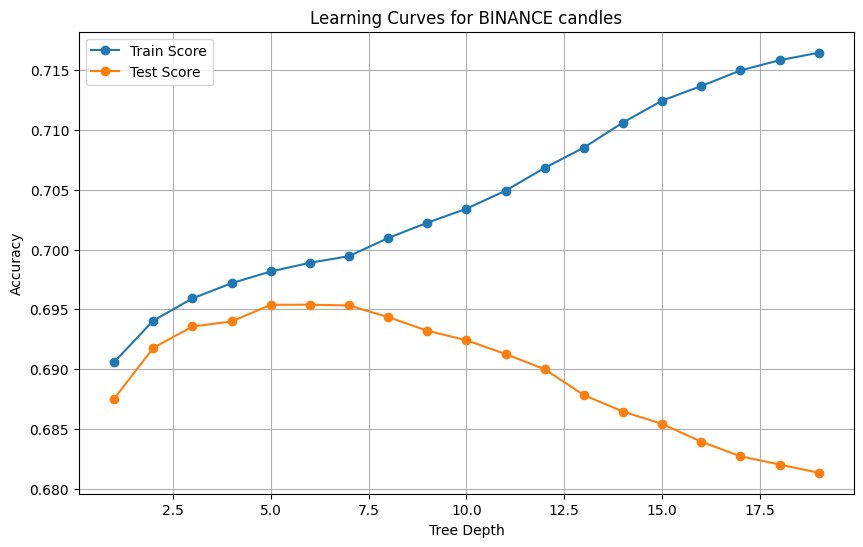

Best parameters for BINANCE orderbooks: {'min_samples_split': 20, 'min_samples_leaf': 30, 'max_depth': 1}


/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

BINANCE orderbooks Accuracy: 0.69
BINANCE orderbooks Classification Report:


,precision,recall,f1-score,support
positive,0.000000,0.000000,0.000000,22109.000000
neutral,0.692356,1.000000,0.818215,99693.000000
negative,0.000000,0.000000,0.000000,22189.000000
accuracy,0.692356,0.692356,0.692356,0.692356
macro avg,0.230785,0.333333,0.272738,143991.000000
weighted avg,0.479357,0.692356,0.566496,143991.000000


BINANCE orderbooks Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,0,22109,0
true:neutral,0,99693,0
true:negative,0,22189,0


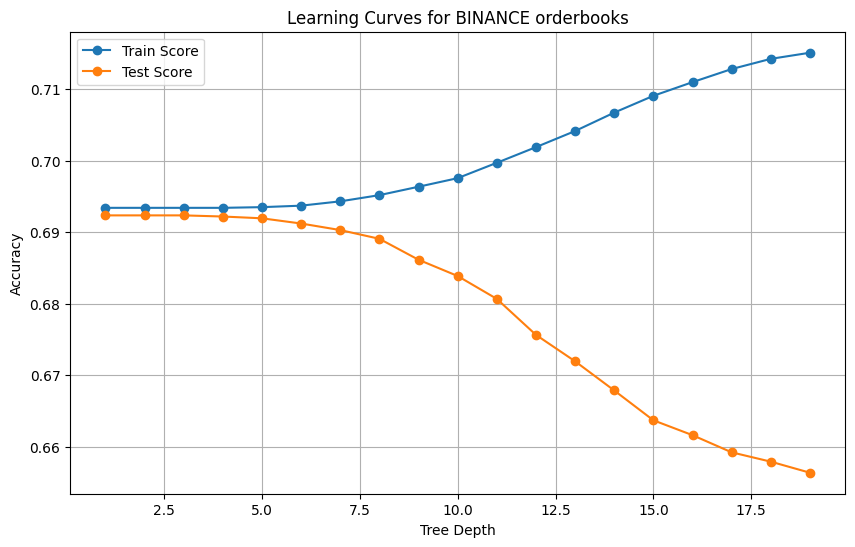

Best parameters for HUOBI candles: {'min_samples_split': 100, 'min_samples_leaf': 50, 'max_depth': 7}
HUOBI candles Accuracy: 0.70
HUOBI candles Classification Report:


,precision,recall,f1-score,support
positive,0.400402,0.032634,0.060349,18294.000000
neutral,0.712007,0.988968,0.827939,84931.000000
negative,0.404265,0.048324,0.086329,18438.000000
accuracy,0.702613,0.702613,0.702613,0.702613
macro avg,0.505558,0.356642,0.324872,121663.000000
weighted avg,0.618514,0.702613,0.600129,121663.000000


HUOBI candles Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,597,16951,746
true:neutral,370,83994,567
true:negative,524,17023,891


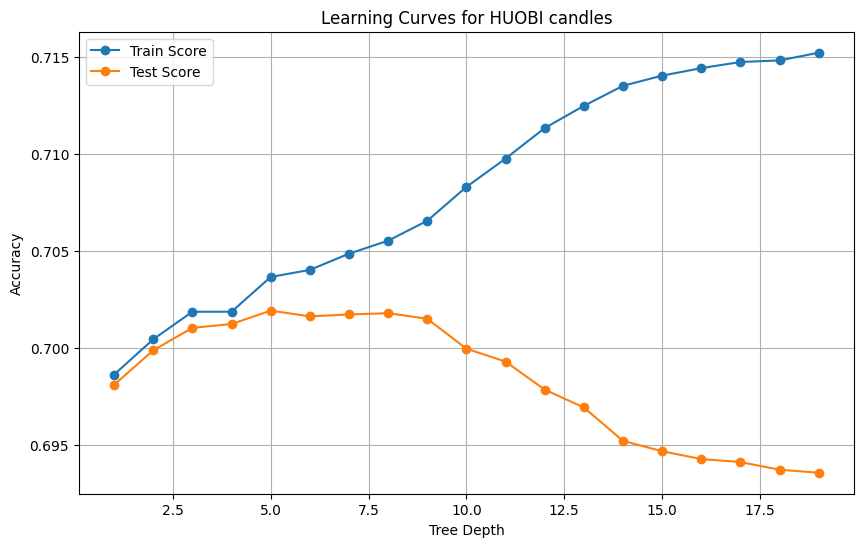

Best parameters for HUOBI orderbooks: {'min_samples_split': 10, 'min_samples_leaf': 50, 'max_depth': 4}


/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


HUOBI orderbooks Accuracy: 0.69
HUOBI orderbooks Classification Report:


/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
positive,0.000000,0.000000,0.000000,18133.00000
neutral,0.690290,1.000000,0.816771,81410.00000
negative,0.000000,0.000000,0.000000,18393.00000
accuracy,0.690290,0.690290,0.690290,0.69029
macro avg,0.230097,0.333333,0.272257,117936.00000
weighted avg,0.476500,0.690290,0.563808,117936.00000


HUOBI orderbooks Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,0,18133,0
true:neutral,0,81410,0
true:negative,0,18393,0


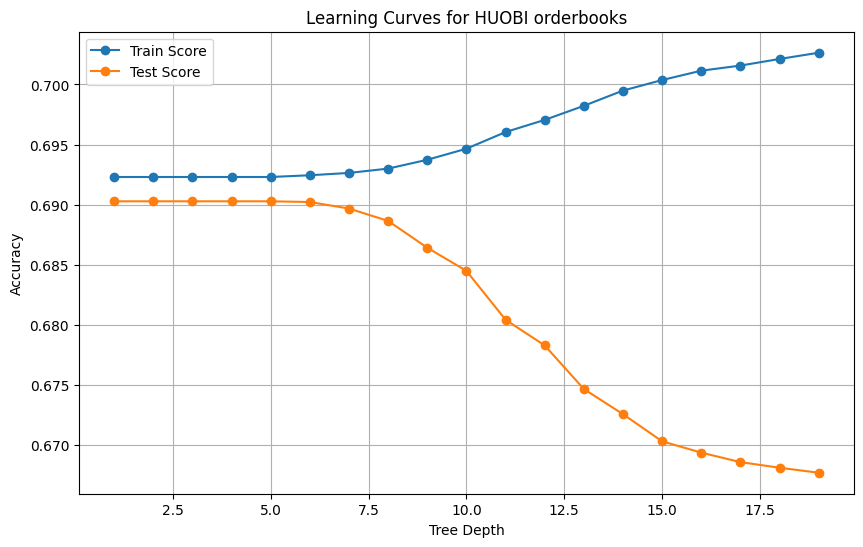

Best parameters for OKX candles: {'min_samples_split': 100, 'min_samples_leaf': 50, 'max_depth': 7}
OKX candles Accuracy: 0.71
OKX candles Classification Report:


,precision,recall,f1-score,support
positive,0.380876,0.064655,0.110545,18297.000000
neutral,0.718820,0.984543,0.830956,85012.000000
negative,0.442036,0.051098,0.091606,18357.000000
accuracy,0.705366,0.705366,0.705366,0.705366
macro avg,0.513911,0.366765,0.344369,121666.000000
weighted avg,0.626236,0.705366,0.611062,121666.000000


OKX candles Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,1183,16422,692
true:neutral,822,83698,492
true:negative,1101,16318,938


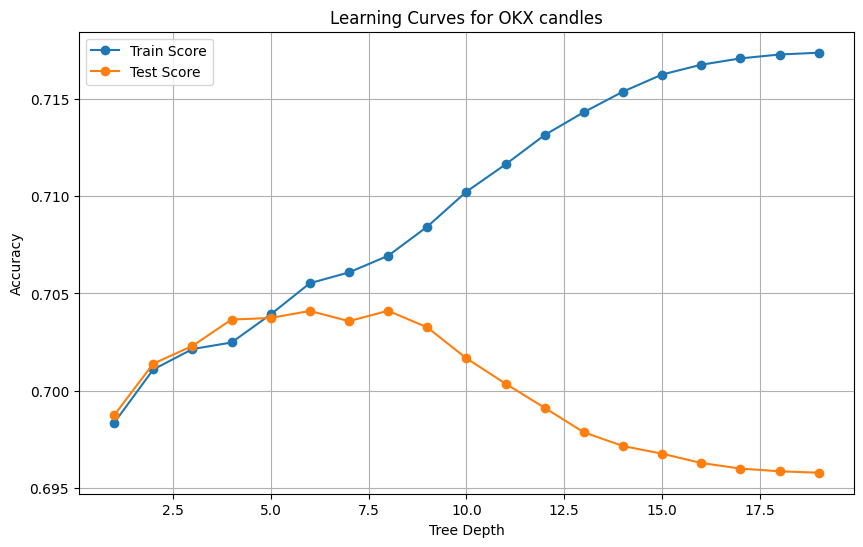

Best parameters for OKX orderbooks: {'min_samples_split': 10, 'min_samples_leaf': 50, 'max_depth': 4}


/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


OKX orderbooks Accuracy: 0.69
OKX orderbooks Classification Report:


/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
positive,0.000000,0.000000,0.000000,18133.00000
neutral,0.690290,1.000000,0.816771,81410.00000
negative,0.000000,0.000000,0.000000,18393.00000
accuracy,0.690290,0.690290,0.690290,0.69029
macro avg,0.230097,0.333333,0.272257,117936.00000
weighted avg,0.476500,0.690290,0.563808,117936.00000


OKX orderbooks Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,0,18133,0
true:neutral,0,81410,0
true:negative,0,18393,0


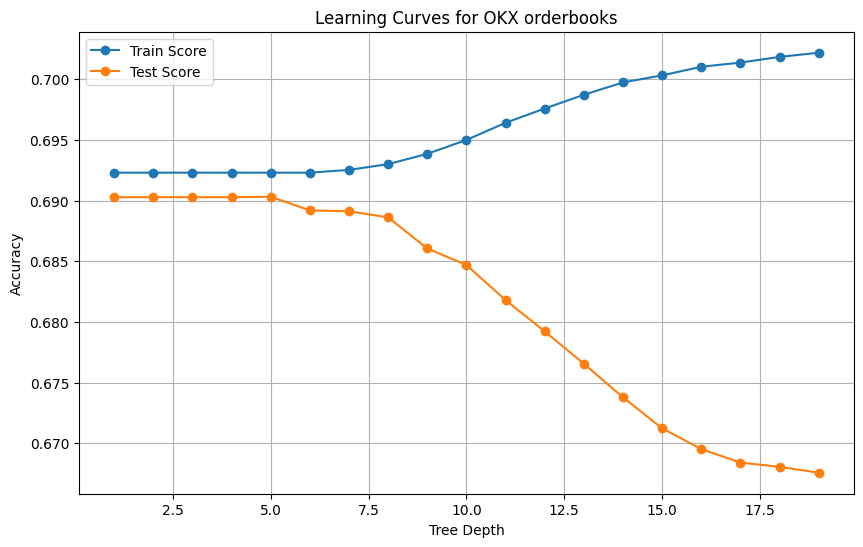

In [7]:
best_params = {}
best_score = {}
evaluation = {}

param_distributions = {
    'max_depth': range(1, 20),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [10, 20, 30, 50]
}

for (data_type, exchange), df in data.items():
    clf = DecisionTreeClassifier(random_state=42)

    # Initialize the RandomizedSearchCV object
    randomized_search = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1, random_state=42)

    # Fit the random search to the data
    randomized_search.fit(df['X_train'], df['y_train'])

    # Best parameters and score
    best_params[(data_type, exchange)] = randomized_search.best_params_
    best_score[(data_type, exchange)] = randomized_search.best_score_
    print(f"Best parameters for {exchange} {data_type}: {best_params[(data_type, exchange)]}")

    # Train the classifier with the best max_depth
    clf = DecisionTreeClassifier(random_state=42, **best_params[(data_type, exchange)])
    clf.fit(df['X_train'], df['y_train'])

    # Predict on the test set
    df['y_pred'] = clf.predict(df['X_test'])

    evaluation[(data_type, exchange)] = {}

    # Calculate accuracy
    evaluation[(data_type, exchange)]['accuracy'] = accuracy_score(df['y_test'], df['y_pred'])

    # Convert classification report to DataFrame
    report = classification_report(df['y_test'], df['y_pred'], target_names=['positive', 'neutral', 'negative'], digits=2, output_dict=True)
    evaluation[(data_type, exchange)]['classification_report'] = pd.DataFrame(report).transpose()

    # Convert confusion matrix to DataFrame
    evaluation[(data_type, exchange)]['confusion_matrix'] = pd.DataFrame(
        confusion_matrix(df['y_test'], df['y_pred']),
        index=['true:positive', 'true:neutral', 'true:negative'],
        columns=['pred:positive', 'pred:neutral', 'pred:negative']
    )
    pd.DataFrame.to_pickle(evaluation, os.path.join(PROCESSED_DATA_PATH, f'{exchange}_{data_type}_evaluation.pkl'))

    # Display results
    print(f'{exchange} {data_type} Accuracy: {evaluation[(data_type, exchange)]["accuracy"]:.2f}')
    print(f'{exchange} {data_type} Classification Report:')
    display(evaluation[(data_type, exchange)]['classification_report'])
    print(f'{exchange} {data_type} Confusion Matrix:')
    display(evaluation[(data_type, exchange)]['confusion_matrix'])    

    # Calculate cross-validated train and test scores for plotting learning curves
    train_scores = []
    test_scores = []
    depths = param_distributions['max_depth']

    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42, 
            min_samples_split=best_params[(data_type, exchange)]['min_samples_split'], 
            min_samples_leaf=best_params[(data_type, exchange)]['min_samples_leaf'],
            class_weight='balanced')            
        model.fit(df['X_train'], df['y_train'])
        train_scores.append(model.score(df['X_train'], df['y_train']))
        test_scores.append(np.mean(cross_val_score(model, df['X_test'], df['y_test'], cv=CV_FOLDS, n_jobs=-1, scoring='accuracy')))

    plot_tree_learning_curves(exchange, data_type, depths, train_scores, test_scores, 'decision_tree')

    pd.DataFrame.to_pickle(best_params[(data_type, exchange)], os.path.join(PROCESSED_DATA_PATH, f'decision_tree_best_params.pkl'))
    pd.DataFrame.to_pickle(best_score[(data_type, exchange)], os.path.join(PROCESSED_DATA_PATH, f'decision_tree_best_score.pkl'))